# Мэтчинг данных

## Введение и цель работы:

Цель анализа – для каждого товара Интернет-магазина подобрать 5 наиболее близких. 

Такую информацию можно в дальнейшем использовать либо для формирований рекомендаций пользователю, либо для анализа конкурентных товаров.

Применительно к нашему набору данных:

Для каждого товара из базы valid нужно найти 5 наиболее близких товаров из базы base.

Задача  - подобрать алгоритм, который выполнил бы эту задачу за разумное время, на основе массива данных по 71 признаку.


## Предварительная обработка и анализ данных

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import faiss
from tqdm.notebook import tqdm
import timeit
import warnings
warnings.filterwarnings("ignore")

In [89]:
%%time
data_train = pd.read_csv('train.csv')
df_base = pd.read_csv("base.csv", index_col=0)
df_train = pd.read_csv("train.csv", index_col=0)
valid = pd.read_csv('validation.csv')
valid_ans = pd.read_csv('validation_answer.csv')


Wall time: 27.1 s


In [90]:
base_sample = df_base.reset_index()
data_train = df_train.reset_index()

In [91]:
data_train.head(5)

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


### Анализ данных на предмет пропусков

In [92]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

In [93]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

In [94]:
valid.head(5)

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


Пропусков в данных нет

### Предварительный анализ (распределения и корреляции)

Посмотрим распределения

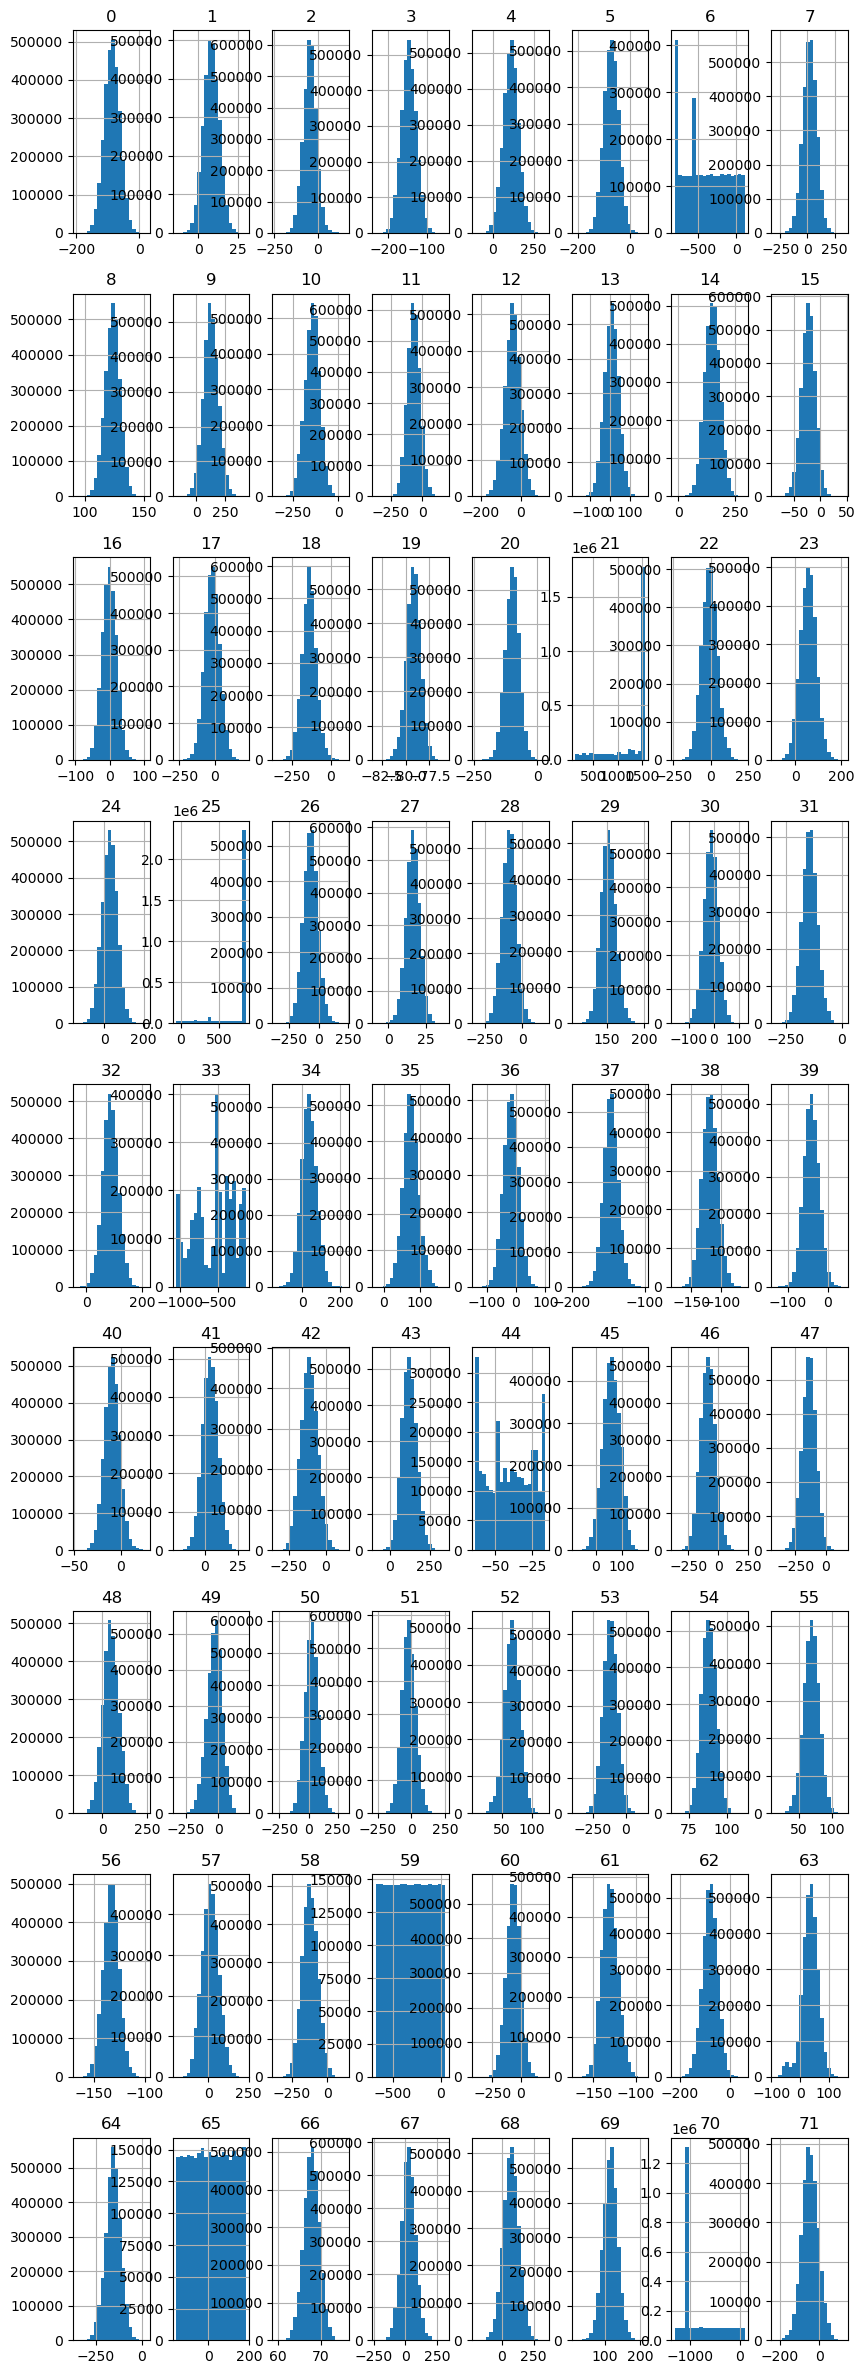

In [95]:
base_sample.hist(bins=20, figsize=(10, 30));

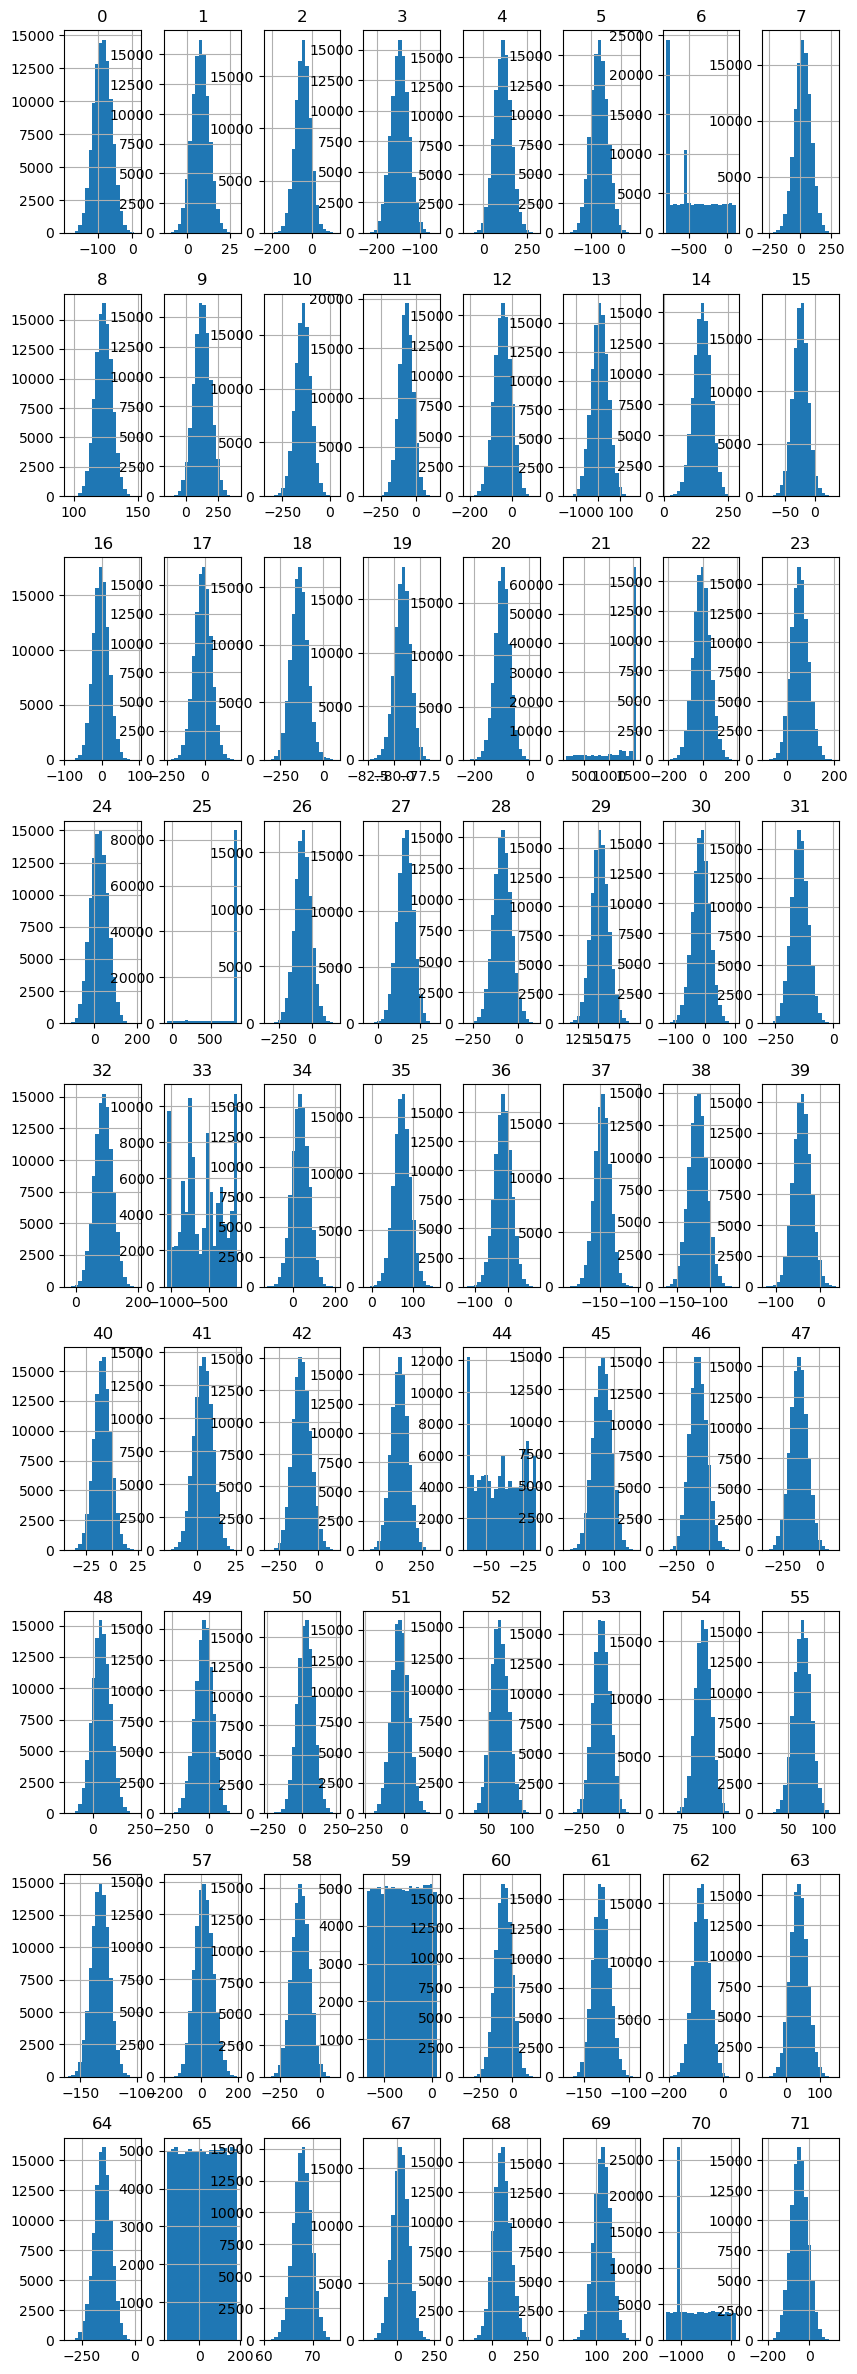

In [96]:
data_train.hist(bins=20, figsize=(10, 30));

Вывод: в целом большинство признаков имеют нормальное распределение. Выбиваются признаки:6,21,25,33,44,59,65,70, но их меньшинство.

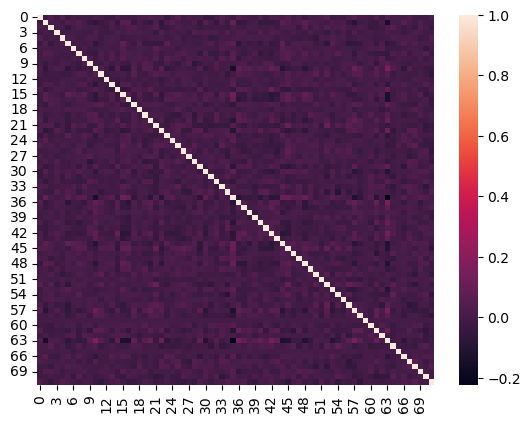

In [97]:
sns.heatmap(base_sample.corr());

Вывод: в целом признаки между собой не коррелируют, поэтому не будем ничего отбрасывать на основе корреляций

### Выделение и масштабирование признаков

In [98]:
data_train = data_train.rename(columns={'Id': 'q_ID'})

In [99]:
features_train = data_train.drop(['q_ID','Target'], axis=1)

In [100]:
features_train_b = base_sample.drop(['Id'], axis=1)

In [101]:
valid_f = pd.concat([valid, valid_ans['Expected']], axis=1)
valid_f = valid_f.rename(columns={'Id': 'q_ID'})
valid_f = valid_f.rename(columns={'Expected': 'Target'})

In [102]:
features_valid = valid_f.drop(['q_ID','Target'], axis=1)

In [103]:
scaler = StandardScaler()
scaler.fit(features_train_b)
features_train = scaler.transform(features_train)
features_train_b = scaler.transform(features_train_b)
features_valid = scaler.transform(features_valid)

## Расчет и тестирование алгоритмов

Базово задача поиска решается с помощью алгоритма KNN. 

Но объем данных очень велик и задача будет считаться неприемлемо долго.

Поэтому мы протестируем следующие подходы:

1. Кластеризация K-means + KNN
2. Библиотека Faiss (с разными настройками)

### Кластеризация K-means + KNN

Прежде всего необходимо определить оптимальное количество кластеров.

Для быстроты расчета сделаем случайную выборку из базы base и попробуем разные варианты кластеризации

In [104]:
base_sample_s = base_sample.sample(10000)
features_train_b_s = base_sample_s.drop(['Id'], axis=1)
features_train_b_s = scaler.transform(features_train_b_s)

In [105]:

sse = []
n_cl = []

for k in range(2, 200, 20):
    kmeans1 = KMeans(n_clusters=k)
    kmeans1.fit(features_train_b_s)
    sse.append(kmeans1.inertia_)
    n_cl.append(k)


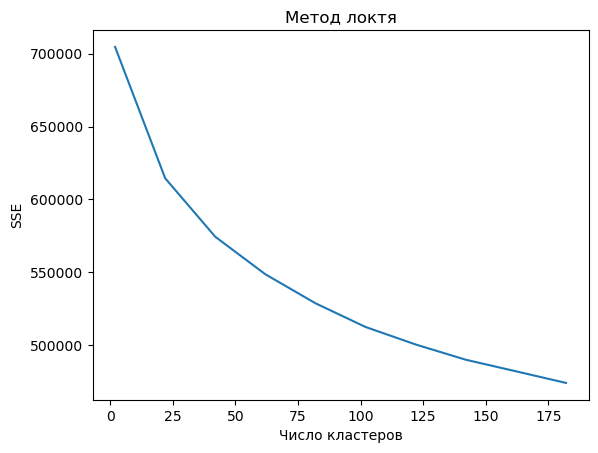

In [106]:
plt.plot(n_cl, sse)
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('SSE')
plt.show()

Оптимальное число кластеров - 60. Далее кластеризуем наш полный набор данных

In [107]:
%%time
kmeans = KMeans(n_clusters=60)

Wall time: 0 ns


In [108]:
%%time
start_time = timeit.default_timer()

#делаем кластеризацию
kmeans.fit(features_train_b)

end_time = timeit.default_timer()
elapsed_time_knn1 = end_time - start_time

Wall time: 16min 42s


In [109]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [110]:
base_sample['cluster'] = labels

In [111]:
centers_inf = pd.DataFrame(centers)

In [112]:
centers_inf

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.526334,0.426180,-0.064161,0.366906,-0.924252,0.445436,0.044871,0.505572,-0.162210,-0.810972,...,-0.725476,-0.003911,0.014180,-0.000304,-0.308632,0.016641,-0.627968,-0.767402,-0.010988,-0.227440
1,-0.471467,1.248972,0.131854,-0.255127,-0.123935,0.828208,0.186524,0.828696,0.308914,-0.423900,...,-0.110413,-2.850188,0.015523,-0.006106,0.485884,-0.290175,0.167988,0.359462,0.513443,-0.390476
2,0.166092,-0.093428,0.183204,0.082638,0.249496,0.139456,-0.011219,0.229826,-0.573750,-0.546199,...,0.451424,0.002867,-0.345132,-0.001731,-0.053241,-0.607041,-0.106738,0.292055,-0.027261,-0.341221
3,-0.521519,0.285674,-0.239702,-0.573872,0.736481,-0.133114,-0.073069,-0.137733,-0.351105,0.587998,...,-0.148793,0.225930,-0.206752,-0.007721,0.450344,-0.042603,0.072346,0.132072,0.115779,0.372827
4,-0.273622,0.366067,-0.125722,0.451081,-0.354605,0.134530,0.003966,0.736540,0.106665,-0.332773,...,0.516463,-0.051990,-0.150482,0.006020,-0.218902,1.461417,-0.346381,0.133689,-0.022376,-0.416812
5,-0.053178,0.638665,-0.320318,-0.244265,-0.867538,-0.880169,0.052113,0.101307,0.953259,0.382547,...,0.181708,0.383249,-0.166455,-0.026175,0.311740,1.245438,0.351667,-0.518817,-0.068227,-0.286180
6,-0.895661,-0.885385,0.354937,0.236748,-0.299615,0.418732,0.022902,0.042954,-1.373117,0.077230,...,-0.452800,-0.382857,-0.498188,0.010620,-1.079832,-0.323039,-0.420736,1.105078,0.052964,1.048899
7,-0.028489,0.013248,-0.407197,-0.894735,1.540716,-0.196496,0.135681,-0.247755,-0.171131,-1.303980,...,-0.880632,-0.436934,0.548408,-0.010063,-1.275029,0.987011,1.530306,-0.625762,-0.014058,0.587035
8,-1.145552,0.376341,0.244371,0.472720,0.280712,-0.778150,-0.005077,-0.253054,-0.428264,-0.044143,...,-0.196547,0.264545,0.176478,0.006161,-0.448561,-0.325183,-0.056628,0.096110,0.060884,0.467492
9,-0.331604,-0.920065,0.312312,-1.192587,0.324343,0.267598,0.021710,0.214524,0.240402,0.360474,...,-0.220852,-0.663383,1.244580,-0.007148,-1.005618,-0.634851,0.375387,0.012839,0.020545,-0.133397


Далее проставим в данных base, train, valid принадлежность к кластерам

In [113]:
knn = NearestNeighbors(n_neighbors=1)

In [114]:
%%time
knn.fit(centers_inf)

Wall time: 4.98 ms


NearestNeighbors(n_neighbors=1)

In [115]:
%%time
distances_tr, indices_tr = knn.kneighbors(features_train)

Wall time: 177 ms


In [116]:
data_train['cluster'] = indices_tr

In [117]:
%%time
distances_val, indices_val = knn.kneighbors(features_valid)

Wall time: 137 ms


In [118]:
valid_f['cluster'] = indices_val

Теперь напишем функцию, которая будет в рамках каждого кластера искать для каждого элемента искомой базы искать 5 ближайших соседей в базе Base.

In [119]:
def find_sim(base_sample, data_train):
    result1 = pd.DataFrame([])
    for i in range(len(centers_inf)):
        base_sample0 = base_sample[base_sample['cluster'] == i]
        data_train0=data_train[data_train['cluster'] == i]
        if len(data_train0)==0:
            continue
        base_sample0 = base_sample0.reset_index()
        base_sample0 = base_sample0.drop(['index'],axis=1)
        data_train0 = data_train0.reset_index()
        data_train0 = data_train0.drop(['index'],axis=1)
        features_sample0 = base_sample0.drop(['Id','cluster'], axis=1)
        features_train0 = data_train0.drop(['q_ID','cluster','Target'], axis=1)
        features_sample0 = scaler.transform(features_sample0)
        features_train0 = scaler.transform(features_train0)
        
        knn0 = NearestNeighbors(n_neighbors=5)
        knn0.fit(features_sample0)
        distances0, indices0 = knn0.kneighbors(features_train0)
        ind_data=pd.DataFrame(indices0, columns=['0n', '1n', '2n','3n','4n'])
        data_train0 = data_train0.reset_index()
        data_train0 = pd.concat([data_train0, ind_data], axis=1)
        
        base_sample0 = base_sample0.reset_index()
        base_sample0 = base_sample0.rename(columns={'index': 'n_index'})
        data_train0 = pd.merge(data_train0, base_sample0[['n_index', 'Id']], left_on='0n', right_on='n_index', how='left')
        data_train0 = data_train0.drop(['n_index'],axis=1)
        data_train0 = data_train0.rename(columns={'Id': '0_n_ID'})
        data_train0 = pd.merge(data_train0, base_sample0[['n_index', 'Id']], left_on='1n', right_on='n_index', how='left')
        data_train0 = data_train0.drop(['n_index'],axis=1)
        data_train0 = data_train0.rename(columns={'Id': '1_n_ID'})
        data_train0 = pd.merge(data_train0, base_sample0[['n_index', 'Id']], left_on='2n', right_on='n_index', how='left')
        data_train0 = data_train0.drop(['n_index'],axis=1)
        data_train0 = data_train0.rename(columns={'Id': '2_n_ID'})
        data_train0 = pd.merge(data_train0, base_sample0[['n_index', 'Id']], left_on='3n', right_on='n_index', how='left')
        data_train0 = data_train0.drop(['n_index'],axis=1)
        data_train0 = data_train0.rename(columns={'Id': '3_n_ID'})
        data_train0 = pd.merge(data_train0, base_sample0[['n_index', 'Id']], left_on='4n', right_on='n_index', how='left')
        data_train0 = data_train0.drop(['n_index'],axis=1)
        data_train0 = data_train0.rename(columns={'Id': '4_n_ID'})
        result1 = pd.concat([result1, data_train0], axis=0)
    return result1

In [120]:
start_time = timeit.default_timer()

train_result = find_sim(base_sample, data_train)


end_time = timeit.default_timer()
elapsed_time_knn2_tr = end_time - start_time

In [121]:
start_time = timeit.default_timer()

valid_result = find_sim(base_sample, valid_f)

end_time = timeit.default_timer()
elapsed_time_knn2_val = end_time - start_time

In [122]:
answer_tr = train_result[['Target','0_n_ID','1_n_ID','2_n_ID','3_n_ID','4_n_ID']]

In [123]:
answer_val = valid_result[['Target','0_n_ID','1_n_ID','2_n_ID','3_n_ID','4_n_ID']]

Рассчитаем accuracy@5

In [124]:
def accuracy_at_5(df):
    num_correct_predictions = 0
    for _, row in df.iterrows():
        if ((row[0] == row[1]) | (row[0] == row[2]) | (row[0] == row[3]) | (row[0] == row[4])) :
            num_correct_predictions += 1
    return num_correct_predictions / len(df)

In [125]:
knn_acc_tr = accuracy_at_5(answer_tr)*100

In [126]:
knn_acc_val = accuracy_at_5(answer_val)*100

In [127]:
knn_time_tr = elapsed_time_knn1+elapsed_time_knn2_tr

In [128]:
knn_time_val = elapsed_time_knn1+elapsed_time_knn2_val

### Faiss

In [129]:
scaler = StandardScaler()
scaler.fit(df_base)
df_base1 = scaler.transform(df_base)

#### Создадим индексы с евклидовым расстоянием и количеством кластеров 60

##### Создание индексов

In [130]:
%%time
dims = df_base.shape[1]
n_cells = 60

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

Wall time: 99.5 ms


In [131]:
%%time
idx_l2.train(np.ascontiguousarray(df_base1[:50000, :]).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base1).astype('float32'))

Wall time: 2.74 s


In [132]:
%%time
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}


Wall time: 1.22 s


##### Посчитаем соседей на обучающей выборке

In [133]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [134]:
df_train = scaler.transform(df_train)

In [135]:
%%time
start_time = timeit.default_timer()

r, idx = idx_l2.search(np.ascontiguousarray(df_train).astype('float32'), 5)

end_time = timeit.default_timer()

elapsed_time_fsev_tr60 = end_time - start_time


Wall time: 38.7 s


In [136]:
%%time
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))
acc_f_ev_tr60 = 100 * acc / len(idx)

55.432
Wall time: 1.9 s


##### Посчитаем соседей на валидационной выборке

In [137]:
df_valid = pd.read_csv("validation.csv", index_col=0)
df_valid = scaler.transform(df_valid)
df_target_val = pd.read_csv("validation_answer.csv", index_col=0)
target_val = df_target_val['Expected']

In [138]:
%%time

start_time = timeit.default_timer()

r, idx = idx_l2.search(np.ascontiguousarray(df_valid).astype('float32'), 5)

end_time = timeit.default_timer()

elapsed_time_fsev_val60 = end_time - start_time

Wall time: 38.6 s


In [139]:
%%time
acc = 0
for target, el in zip(target_val.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))
acc_f_ev_val60 = 100 * acc / len(idx)

55.25
Wall time: 335 ms


#### Создадим индексы с евклидовым расстоянием и количеством кластеров 1

##### Создание индексов

In [140]:
%%time
dims = df_base.shape[1]
n_cells = 1

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

Wall time: 95.5 ms


In [141]:
%%time
idx_l2.train(np.ascontiguousarray(df_base1[:50000, :]).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base1).astype('float32'))

Wall time: 2.87 s


In [142]:
%%time
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}


Wall time: 376 ms


##### Посчитаем соседей на обучающей выборке

In [143]:
%%time
start_time = timeit.default_timer()

r, idx = idx_l2.search(np.ascontiguousarray(df_train).astype('float32'), 5)

end_time = timeit.default_timer()

elapsed_time_fsev_tr1 = end_time - start_time


Wall time: 36min 42s


In [144]:
%%time
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))
acc_f_ev_tr1 = 100 * acc / len(idx)

65.838
Wall time: 351 ms


##### Посчитаем соседей на валидационной выборке

In [145]:
df_valid = pd.read_csv("validation.csv", index_col=0)
df_valid = scaler.transform(df_valid)
df_target_val = pd.read_csv("validation_answer.csv", index_col=0)
target_val = df_target_val['Expected']

In [146]:
%%time

start_time = timeit.default_timer()

r, idx = idx_l2.search(np.ascontiguousarray(df_valid).astype('float32'), 5)

end_time = timeit.default_timer()

elapsed_time_fsev_val1 = end_time - start_time

Wall time: 35min 55s


In [147]:
%%time
acc = 0
for target, el in zip(target_val.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))
acc_f_ev_val1 = 100 * acc / len(idx)

65.658
Wall time: 352 ms


#### Создадим индексы с косинусным расстоянием и количеством кластеров 60

##### Создание индексов

In [148]:
%%time
dims = df_base.shape[1]
n_cells = 60

quantizer = faiss.IndexFlatIP(dims)
idx_l21 = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_INNER_PRODUCT)

Wall time: 70.7 ms


In [149]:
%%time
idx_l21.train(np.ascontiguousarray(df_base1[:200000, :]).astype('float32'))

idx_l21.add(np.ascontiguousarray(df_base1).astype('float32'))

Wall time: 2.47 s


In [150]:
%%time
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}


Wall time: 427 ms


##### Посчитаем соседей на обучающей выборке

In [151]:
%%time
start_time = timeit.default_timer()

r, idx = idx_l21.search(np.ascontiguousarray(df_train).astype('float32'), 5)

end_time = timeit.default_timer()

elapsed_time_fscos_tr60 = end_time - start_time


Wall time: 37 s


In [152]:
%%time
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))
acc_f_cos_tr60 = 100 * acc / len(idx)

53.887
Wall time: 397 ms


##### Посчитаем соседей на валидационной выборке

In [153]:
%%time
start_time = timeit.default_timer()

r, idx = idx_l21.search(np.ascontiguousarray(df_valid).astype('float32'), 5)

end_time = timeit.default_timer()

elapsed_time_fscos_val60 = end_time - start_time

Wall time: 36.9 s


In [154]:
%%time
acc = 0
for target, el in zip(target_val.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))
acc_f_cos_val60 = 100 * acc / len(idx)

53.427
Wall time: 423 ms


#### Создадим индексы с косинусным расстоянием и количеством кластеров 1

##### Создание индексов

In [155]:
%%time
dims = df_base.shape[1]
n_cells = 1

quantizer = faiss.IndexFlatIP(dims)
idx_l21 = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_INNER_PRODUCT)

Wall time: 93.1 ms


In [156]:
%%time
idx_l21.train(np.ascontiguousarray(df_base1[:200000, :]).astype('float32'))

idx_l21.add(np.ascontiguousarray(df_base1).astype('float32'))

Wall time: 3.08 s


In [157]:
%%time
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}


Wall time: 373 ms


##### Посчитаем соседей на обучающей выборке

In [158]:
%%time
start_time = timeit.default_timer()

r, idx = idx_l21.search(np.ascontiguousarray(df_train).astype('float32'), 5)

end_time = timeit.default_timer()

elapsed_time_fscos_tr1 = end_time - start_time


Wall time: 35min 34s


In [159]:
%%time
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))
acc_f_cos_tr1 = 100 * acc / len(idx)

62.968
Wall time: 339 ms


##### Посчитаем соседей на валидационной выборке

In [160]:
%%time
start_time = timeit.default_timer()

r, idx = idx_l21.search(np.ascontiguousarray(df_valid).astype('float32'), 5)

end_time = timeit.default_timer()

elapsed_time_fscos_val1 = end_time - start_time

Wall time: 35min 48s


In [161]:
%%time
acc = 0
for target, el in zip(target_val.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))
acc_f_cos_val1 = 100 * acc / len(idx)

62.705
Wall time: 413 ms


### Summary результатов алгоритмов

In [165]:
summary = {'Алгоритм': ['Kmeans+KNN', 'Kmeans+KNN', 'Faiss (IFV Index р-е евклидово)',
                        'Faiss (IFV Index р-е евклидово)', 'Faiss (IFV Index р-е евклидово)',
                        'Faiss (IFV Index р-е евклидово)','Faiss (IFV Index р-е косинусное)','Faiss (IFV Index р-е косинусное)', 
                        'Faiss (IFV Index р-е косинусное)','Faiss (IFV Index р-е косинусное)'], 
           'Тип данных': ['Train', 'Valid', 'Train', 'Valid','Train', 'Valid', 'Train', 'Valid','Train', 'Valid'], 
           'Кол-во кластеров': [60, 60, 60, 60,1,1, 60, 60,1,1], 
           
           'Accuracy@5': [knn_acc_tr, knn_acc_val, acc_f_ev_tr60,acc_f_ev_val60,acc_f_ev_tr1,acc_f_ev_val1,acc_f_cos_tr60,acc_f_cos_val60,acc_f_cos_tr1,acc_f_cos_val1], 
           'Время, с': [knn_time_tr, knn_time_val, elapsed_time_fsev_tr60,elapsed_time_fsev_val60,elapsed_time_fsev_tr1,elapsed_time_fsev_val1,
                     elapsed_time_fscos_tr60,elapsed_time_fscos_val60,elapsed_time_fscos_tr1,elapsed_time_fscos_val1]}
summary_table = pd.DataFrame(summary)
summary_table

,Алгоритм,Тип данных,Кол-во кластеров,Accuracy@5,"Время, с"
0,Kmeans+KNN,Train,60,54.386,1131.658816
1,Kmeans+KNN,Valid,60,54.108,1128.393084
2,Faiss (IFV Index р-е евклидово),Train,60,55.432,38.684941
3,Faiss (IFV Index р-е евклидово),Valid,60,55.250,38.635482
4,Faiss (IFV Index р-е евклидово),Train,1,65.838,2202.998650
5,Faiss (IFV Index р-е евклидово),Valid,1,65.658,2155.389736
6,Faiss (IFV Index р-е косинусное),Train,60,53.887,37.007419
7,Faiss (IFV Index р-е косинусное),Valid,60,53.427,36.855901
8,Faiss (IFV Index р-е косинусное),Train,1,62.968,2134.347487
9,Faiss (IFV Index р-е косинусное),Valid,1,62.705,2148.965749


Вывод: лучше всего с точки зрения качества работает Faiss с использованием евклидова расстояния без кластеризации (с 1 кластером). Но и занимает больше всего времени

При этом по сравнению с KMeans+KNN при схожих вводных (60 кластеров) Faiss  сокращает время расчетов в 30 раз (на валидационной выборке) и достигает такого же уровня Accuracy@5 (~55%)

## Общий вывод

Цель анализа – для каждого товара подобрать 5 наиболее близких и нужно подобрать алгоритм, который выполнил бы эту задачу за разумное время, на основе массива данных по 71 признаку.

Проверили признаки, большинство нормально распределены.

Корреляций между признаками нет.

Сделали масштабирование признаков с использованием Standard Scaler

Проверили 3 алгоритма:

1. K-Means кластеризация + KNN. Определили, что оптимальное число кластеров 60.

2. Faiss (IFV Index с использованием евклидова расстояния)

3. Faiss (IFV Index с использованием косинусного  расстояния)

Оптимальный результат дал алгоритм Faiss (IFV Index с использованием евклидова расстояния)
